# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')
import scipy.stats as stats

import yfinance as yf

In [96]:
#load data for Amazon, Microsoft, Google, Ford, and General Motors stock
tickers = ['AMZN','MSFT','GOOG','F','GM']
start_date = dt.datetime.today() - dt.timedelta(days=252)
end_date = dt.datetime.today()

#pull out data for 252 days
stock = yf.download(tickers, start=start_date, end=end_date)


/var/folders/dv/xq3vbg2x22zfk35z4q64z0br0000gn/T/ipykernel_65287/839019297.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed


In [21]:
stock.head()

Price            Close                                                \
Ticker            AMZN          F         GM        GOOG        MSFT   
Date                                                                   
2024-10-18  188.990005  10.452137  48.789330  164.477661  415.726349   
2024-10-21  189.070007  10.244978  48.541313  165.225067  416.342743   
2024-10-22  189.699997  10.461554  53.303185  166.241531  425.021942   
2024-10-23  184.710007  10.414473  52.499619  163.909622  422.128876   
2024-10-24  186.380005  10.583966  52.301208  163.959457  422.258118   

Price             High                                                ...  \
Ticker            AMZN          F         GM        GOOG        MSFT  ...   
Date                                                                  ...   
2024-10-18  190.740005  10.518051  49.354801  165.793076  417.207667  ...   
2024-10-21  189.460007  10.508635  49.205989  165.643609  416.521688  ...   
2024-10-22  191.520004  10.499219  53.749611  166.889271  428.074052  ...   
2024-10-23  189.160004  10.583966  53.759531  167.018813  428.571143  ...   
2024-10-24  187.110001  10.593383  53.868655  164.477658  423.500843  ...   

Price             Open                                                \
Ticker            AMZN          F         GM        GOOG        MSFT   
Date                                                                   
2024-10-18  187.149994  10.508635  49.245675  164.298277  414.712296   
2024-10-21  188.050003  10.433305  48.868690  164.009296  413.698220   
2024-10-22  188.350006  10.282644  49.622657  164.128872  416.054418   
2024-10-23  188.850006  10.461554  53.620643  165.852857  428.352423   
2024-10-24  185.250000  10.583966  53.223821  164.019247  422.854601   

Price         Volume                                          
Ticker          AMZN         F        GM      GOOG      MSFT  
Date                                                          
2024-10-18  37417700  26074900   9500100  13091300  17145300  
2024-10-21  24639400  41008600  11492100  11384000  14206100  
2024-10-22  29650600  51597600  42657700  11958600  25482200  
2024-10-23  31937100  37335400  16109800  12754300  19654400  
2024-10-24  21647400  44736400  11800700  12764400  13581600  

[5 rows x 25 columns]

/var/folders/dv/xq3vbg2x22zfk35z4q64z0br0000gn/T/ipykernel_65287/3661863785.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  closes = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  5 of 5 completed


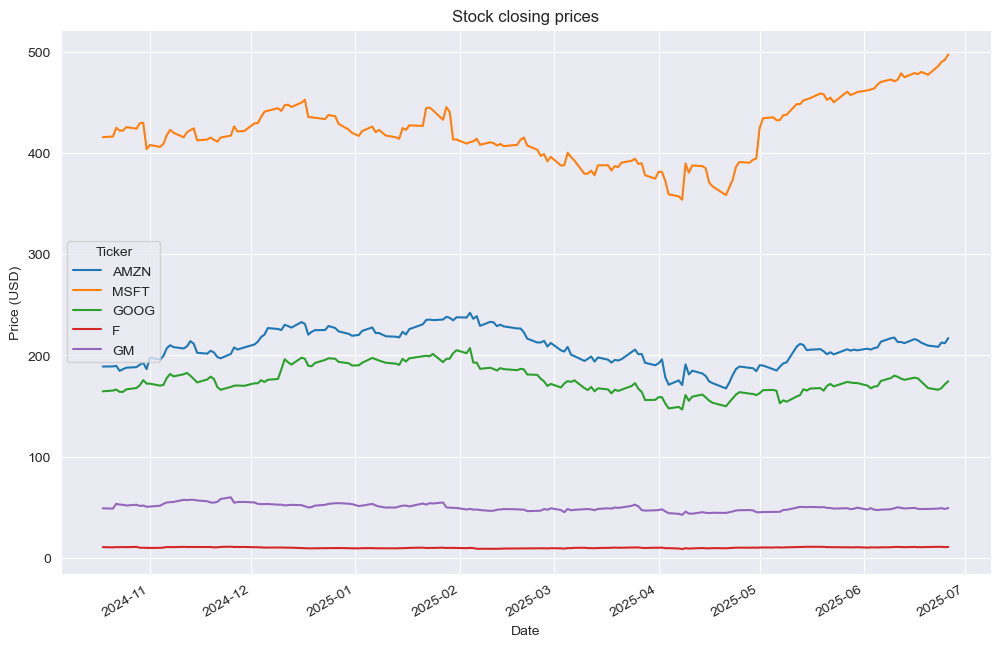

In [22]:
#Plot Closing Price of selected stock data
closes = yf.download(tickers, start=start_date, end=end_date)['Close']
closes[['AMZN','MSFT','GOOG','F','GM']].plot(figsize=(12,8))
plt.title('Stock closing prices')
plt.ylabel('Price (USD)')
plt.show()



In [23]:
#Create a dataframe of daily returns
#It is quite common to take the logs of daily returns to lessen computational complexity in standard deviation
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()

#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}

In [24]:
annualized_volatility

{'AMZN': 0.36076163304921516,
 'MSFT': 0.27703206601316427,
 'GOOG': 0.3440860459099343,
 'F': 0.35072457617273645,
 'GM': 0.3913211743275342}

In [35]:
annualized_returns = daily_returns.mean() * 252
annualized_returns

Ticker
AMZN    0.205685
F       0.025013
GM      0.011219
GOOG    0.087086
MSFT    0.266035
dtype: float64

In [26]:
# Calculate the covariance matrix
covariance_matrix = 252*((daily_returns).cov())
covariance_matrix

Ticker,AMZN,F,GM,GOOG,MSFT
Ticker,,,,,
AMZN,0.130919,0.046472,0.055524,0.084428,0.074141
F,0.046472,0.123736,0.093329,0.037302,0.029233
GM,0.055524,0.093329,0.154038,0.039603,0.031986
GOOG,0.084428,0.037302,0.039603,0.119096,0.054275
MSFT,0.074141,0.029233,0.031986,0.054275,0.077201


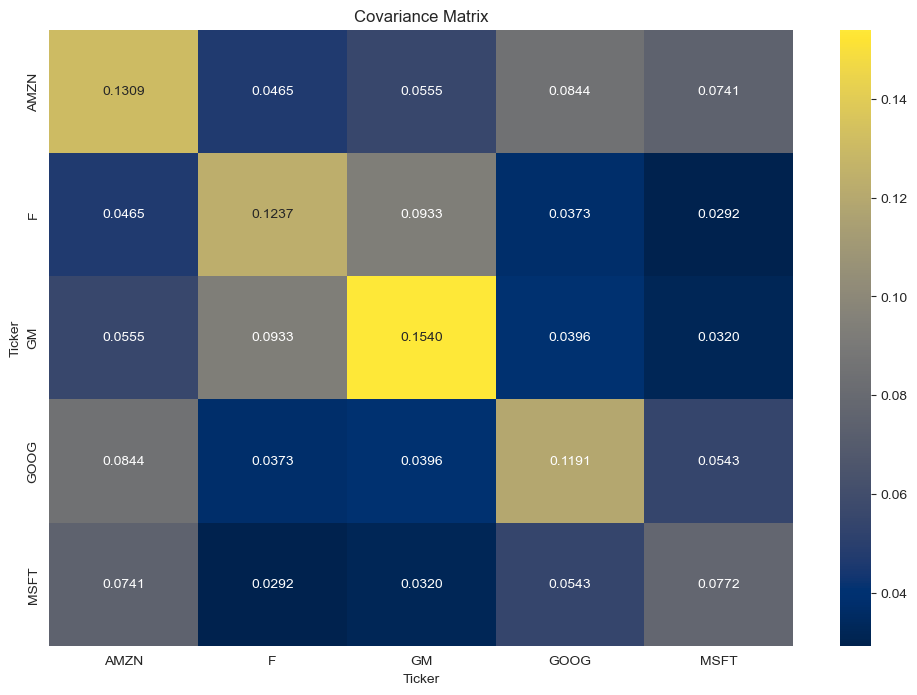

In [27]:
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

In [28]:
# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1 
#Allocate at least 10% of capital into each index in stock_symbols
#Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.1},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Low-risk portfolio: minimize volatility
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize volatility:
AMZN: Weight = 0.1000
MSFT: Weight = 0.2629
GOOG: Weight = 0.1006
F: Weight = 0.1865
GM: Weight = 0.3500


In [29]:
print(f' The optimal volatility subject to the constraints is {result.fun}')

 The optimal volatility subject to the constraints is 0.24843089796766887


In [30]:
#High-risk portfolio: maximize expected return 
result_high = minimize(lambda w: -np.dot(w, annualized_returns),initial_weights,constraints=constraints)

In [31]:
optimal_weights_high = result_high.x
# Print the optimal weights and expected returns
print("Optimal Asset Weights to maximize expected return :")
for ticker, weight in zip(tickers, optimal_weights_high):
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to maximize expected return :
AMZN: Weight = 0.3500
MSFT: Weight = 0.1000
GOOG: Weight = 0.1000
F: Weight = 0.1000
GM: Weight = 0.3500


In [32]:
print(f' The optimal volatility subject to the constraints is {portfolio_volatility(result_high.x)}')

 The optimal volatility subject to the constraints is 0.2686386581020537


In [33]:
return_low  = np.dot(optimal_weights,annualized_returns)
return_high = np.dot(optimal_weights_high,annualized_returns)
print(f"Annualized Expected returns of low-risk portfolio is {return_low:.2%}")
print(f"Annualized Expected returns high-risk portfolio is {return_high:.2%}")


Annualized Expected returns of low-risk portfolio is 13.76%
Annualized Expected returns high-risk portfolio is 17.74%


In conclusion, low risk portfolio has $13.76\%$ return rate with lower risk as its volatility is $24.84\%$; high risk portfolio has $17.74\%$ return rate with higher risk as its volatility is $26.86\%$. The main difference is the high-risk portfolio tends to invested heavier towards Amazon for best return, with an increased risk, and to pull out investment towards more stable but less profitable stocks such as Microsoft. 

# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:

    1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
    
    2) Test if removing extremal return data creates a distribution with evidence of being normal.
    
    3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    
    5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

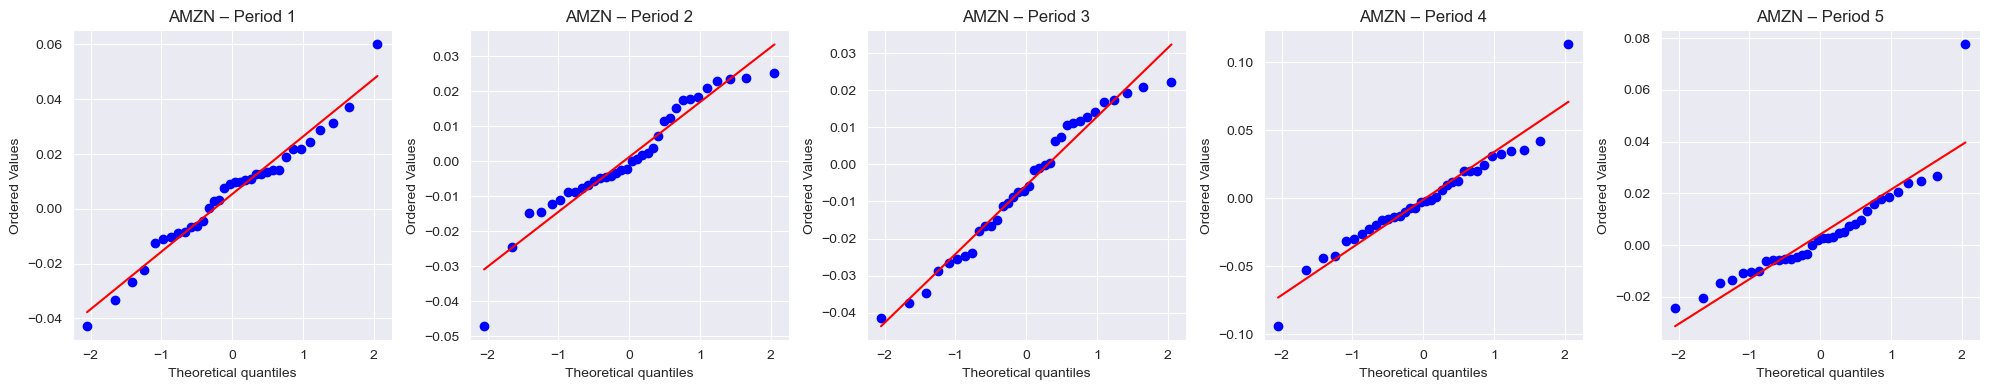

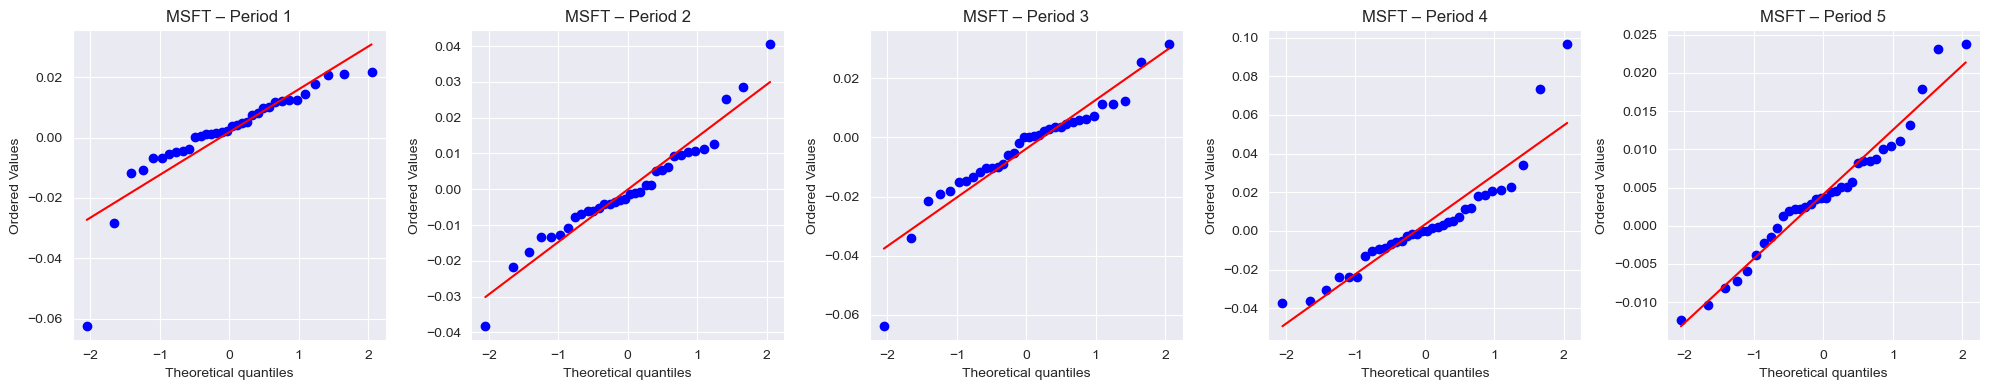

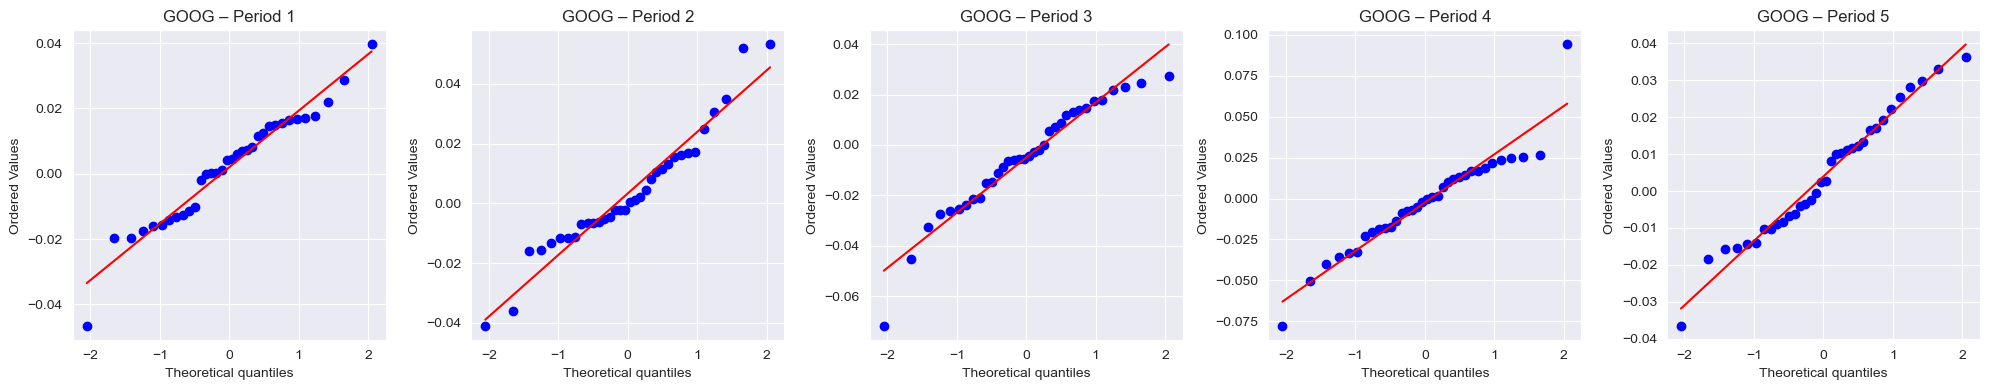

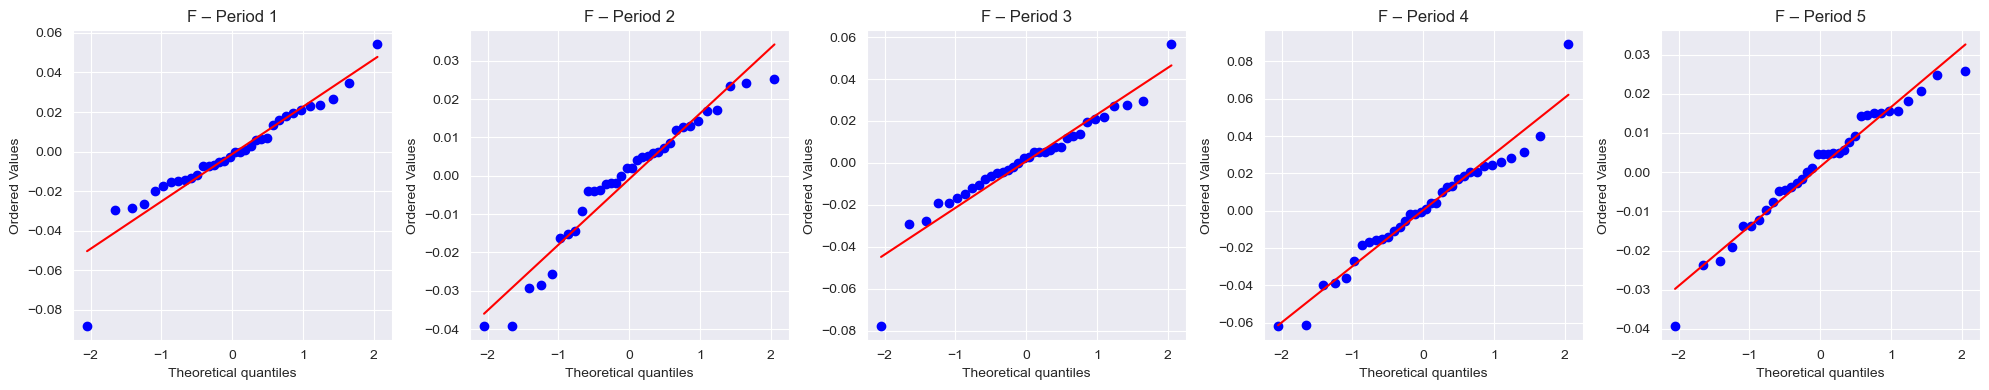

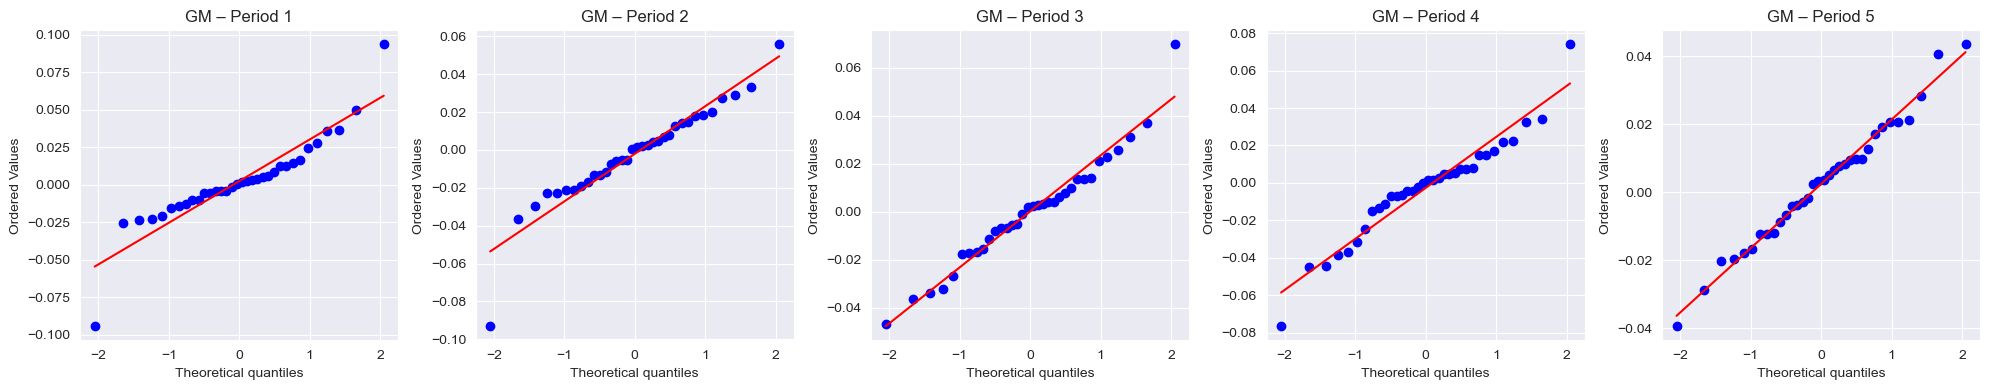

In [45]:
#1) For each ticker, split its log-return series into 5 equal periods
# and draw a 1×5 grid of Q–Q plots to compare against a Normal.
for t in tickers:
    # pull out the log-returns and drop any NaNs
    data = daily_returns[t].dropna()
    
    # split into 5 roughly equal chunks
    chunks = np.array_split(data, 5)

    # create a row of 5 plots
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    # plot each chunk’s Q–Q against the Normal
    for i, (ax, chunk) in enumerate(zip(axes, chunks), start=1):
        stats.probplot(chunk, dist="norm", plot=ax)
        ax.set_title(f"{t} – Period {i}")
    
    plt.tight_layout()
    plt.show()

From eyespotting them, all periods of each stock locate around the red line with only mild deviations in the tails. To be precise, we check other tests. Since each period is relatively small, roughly 50 days, so using the Shapiro–Wilk is a better choice as other tests (D’Agostino–Pearson and Kolmogorov–Smirnov) relies on larger samples. 

In [67]:
# For each ticker, split its log‐returns into n_folds and run three normality tests
for t in tickers:
    data = daily_returns[t].dropna()
    folds  = np.array_split(data, 5)
    
    print(f"\n{t} ")
    
    for i, chunk in enumerate(folds,1):
        
        p_value = stats.shapiro(chunk)[1]
       
        result = "Normal" if p_value > 0.05 else "NOT Normal"
        
        print(f"Period {i}: {result}")


AMZN 
Period 1: Normal
Period 2: NOT Normal
Period 3: Normal
Period 4: Normal
Period 5: NOT Normal

MSFT 
Period 1: NOT Normal
Period 2: Normal
Period 3: NOT Normal
Period 4: NOT Normal
Period 5: Normal

GOOG 
Period 1: Normal
Period 2: Normal
Period 3: Normal
Period 4: Normal
Period 5: Normal

F 
Period 1: NOT Normal
Period 2: Normal
Period 3: NOT Normal
Period 4: Normal
Period 5: Normal

GM 
Period 1: NOT Normal
Period 2: NOT Normal
Period 3: Normal
Period 4: Normal
Period 5: Normal


/Users/houbowang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [69]:
#2) Test if removing extremal return data creates a distribution with evidence of being normal.
for t in tickers:
    data = daily_returns[t].dropna()
    print(f"\n{t} removed 1% extreme")
    
    for i, chunk in enumerate(np.array_split(data, 5), 1):
        
        # drop the bottom/top 1% of returns
        lo, hi = chunk.quantile([0.01, 0.99])
        trimmed = chunk[(chunk >= lo) & (chunk <= hi)]
        
        # Shapiro–Wilk on the trimmed sub-period
        p_value = stats.shapiro(trimmed)[1]
        result = "Normal" if p_value > 0.05 else "NOT Normal"
        
        print(f"Period {i}: {result}")


AMZN removed 1% extreme
Period 1: Normal
Period 2: Normal
Period 3: Normal
Period 4: Normal
Period 5: Normal

MSFT removed 1% extreme
Period 1: Normal
Period 2: Normal
Period 3: Normal
Period 4: NOT Normal
Period 5: Normal

GOOG removed 1% extreme
Period 1: Normal
Period 2: Normal
Period 3: Normal
Period 4: Normal
Period 5: Normal

F removed 1% extreme
Period 1: Normal
Period 2: Normal
Period 3: Normal
Period 4: Normal
Period 5: Normal

GM removed 1% extreme
Period 1: Normal
Period 2: Normal
Period 3: Normal
Period 4: Normal
Period 5: Normal


/Users/houbowang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/houbowang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/houbowang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/houbowang/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/houbowang/anaconda3/l

In [78]:
#3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.

n_portfolios = 10000
best_p, best_w = 0, None

# Dirichlet‐sampling over weight combinaitions to maximize Shapiro–Wilk p-value
for w in np.random.dirichlet(np.ones(len(tickers)), n_portfolios):
    p = stats.shapiro(daily_returns.dot(w).dropna())[1]
    
    if p > best_p:
        best_p, best_w = p, w

print(f"\nbest Shapiro–Wilk p = {best_p:.4f}")
print("weights:")

for t, wt in zip(tickers, best_w):
    print(f"  {t}: {wt:.1%}")


best Shapiro–Wilk p = 0.0024
weights:
  AMZN: 0.2%
  MSFT: 1.7%
  GOOG: 51.4%
  F: 45.8%
  GM: 0.9%


In [79]:
#4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.

In [86]:
#low-risk with optimal_weights:

weights = optimal_weights  
ret = daily_returns.dot(weights).dropna()

print("Normality check of low-risk portfolio log-returns by period:")
for i, chunk in enumerate(np.array_split(ret, 5), 1):
    p = stats.shapiro(chunk)[1]
    status = "Normal" if p > 0.05 else "NOT Normal"
    print(f" Period {i}: {status} (p={p:.3f})")

Normality check of low-risk portfolio log-returns by period:
 Period 1: Normal (p=0.245)
 Period 2: Normal (p=0.193)
 Period 3: Normal (p=0.100)
 Period 4: NOT Normal (p=0.011)
 Period 5: Normal (p=0.262)


Four of the five periods show Normal (p‐values above 0.05), only Period 4 is NOT Normal (p≈0.011). Most of the time of the low-risk portfolio has returns behaving Normally distributed, with just one short period of non-Normal behaviors.

In [87]:
# high-risk with optimal_weights_high:

weights = optimal_weights_high 
ret = daily_returns.dot(weights).dropna()

print("Normality check of high-risk portfolio log-returns by period:")
for i, chunk in enumerate(np.array_split(ret, 5), 1):
    p = stats.shapiro(chunk)[1]
    status = "Normal" if p > 0.05 else "NOT Normal"
    print(f" Period {i}: {status} (p={p:.3f})")

Normality check of high-risk portfolio log-returns by period:
 Period 1: Normal (p=0.066)
 Period 2: Normal (p=0.092)
 Period 3: Normal (p=0.326)
 Period 4: NOT Normal (p=0.017)
 Period 5: NOT Normal (p=0.001)


Only Periods 1–3 pass the Normal test. Period 4 (p≈0.017) and Period 5 (p≈0.001) both reject Normality—because concentrating weights on the highest‐return stocks amplifies the extremes ups and downs.

Therefore, low‐variance combination not only reduces overall risk but also produces returns that follow the Normal distribution more consistently over time. The high‐risk combination, aimed at chasing greater gains, yields more heavy‐tailed behavior in some periods, so it fails the Normality assumption more often than the low-risk combination.

In [88]:
#5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

In [97]:
#Take the full list of S&P 500 tickers from Wikipedia

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500 = pd.read_html(url, header=0)[0]
test_tickers = sp500['Symbol'].tolist()

test_stocks = yf.download(test_tickers, start=start_date, end=end_date)['Close']
return_test = np.log(test_stocks / test_stocks.shift(1)).dropna()

print("\nShapiro–Wilk on each S&P 500 companies:")
for t in test_tickers:
    p_value = stats.shapiro(return_test[t])[1]
    result = "Normal" if p_value > 0.05 else " "
    print(f"{t}: {result}")


/var/folders/dv/xq3vbg2x22zfk35z4q64z0br0000gn/T/ipykernel_65287/3571103807.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_stocks = yf.download(test_tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-10-18 06:08:49.316852 -> 2025-06-27 06:08:49.316929)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')



Shapiro–Wilk on each S&P 500 companies:
MMM:  
AOS:  
ABT:  
ABBV:  
ACN:  
ADBE:  
AMD:  
AES:  
AFL:  
A:  
APD:  
ABNB:  
AKAM:  
ALB:  
ARE:  
ALGN:  
ALLE:  
LNT:  
ALL:  
GOOGL:  
GOOG:  
MO:  
AMZN:  
AMCR:  
AEE:  
AEP:  
AXP:  
AIG:  
AMT:  
AWK:  
AMP:  
AME:  
AMGN:  
APH:  
ADI:  
ANSS:  
AON:  
APA:  
APO:  
AAPL:  
AMAT:  
APTV:  
ACGL:  
ADM:  
ANET:  
AJG:  
AIZ:  
T:  
ATO:  
ADSK:  
ADP:  
AZO:  
AVB:  
AVY:  
AXON:  
BKR:  
BALL:  
BAC:  
BAX:  
BDX:  
BRK.B:  
BBY:  
TECH:  
BIIB:  
BLK:  
BX:  
BK:  
BA:  
BKNG:  
BSX:  
BMY:  
AVGO:  
BR:  
BRO:  
BF.B:  
BLDR:  
BG:  
BXP:  
CHRW:  
CDNS:  
CZR:  
CPT:  
CPB:  
COF:  
CAH:  
KMX:  
CCL:  
CARR:  
CAT:  
CBOE:  
CBRE:  
CDW:  
COR:  
CNC:  
CNP:  
CF:  
CRL:  
SCHW:  
CHTR:  
CVX:  
CMG:  
CB:  
CHD:  
CI:  
CINF:  
CTAS:  
CSCO:  
C:  
CFG:  
CLX:  
CME:  
CMS:  
KO:  
CTSH:  
COIN:  
CL:  
CMCSA:  
CAG:  
COP:  
ED:  
STZ:  
CEG:  
COO:  
CPRT:  
GLW:  
CPAY:  
CTVA:  
CSGP:  
COST:  
CTRA:  
CRWD:  
CCI:  
CSX

/var/folders/dv/xq3vbg2x22zfk35z4q64z0br0000gn/T/ipykernel_65287/3571103807.py:12: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  p_value = stats.shapiro(return_test[t])[1]


It looks like none of them is overall normally distributed...